# Climate Change Classification - Sentiment analysis

## Introduction

In this predict I will try and classify Twitter users sentiment regarding climate change using machine learning models. The different classes to consider are 2: which are links to factual news regarding climate change, 1: supports belief of man-made climate change, 0: neither support or refutes (neutral), -1: does npd believe in man-made climate change.

## Imports

In [68]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import sklearn
import sklearn.metrics
import nltk
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
sns.set()
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.utils import resample
from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 
from sklearn.svm import LinearSVC

## Loading datasets

In [49]:
test = pd.read_csv("test.csv") # this is the testing data, i.e. tweets without the sentiment label
train = pd.read_csv("train.csv") # this is the testing data, i.e tweets with the sentiment label

## EDA

In [34]:
test_df.head(10)

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928
5,RT @nycjim: Trump muzzles employees of several...,75639
6,@bmastenbrook yes wrote that in 3rd yr Comp Sc...,211536
7,RT @climatehawk1: Indonesian farmers weather #...,569434
8,RT @guardian: British scientists face a ‘huge ...,315368
9,Aid For Agriculture | Sustainable agriculture ...,591733


In [35]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


I suspect the data may be imbalanced, so lets take a look at that.

[1, 2, 0, -1]


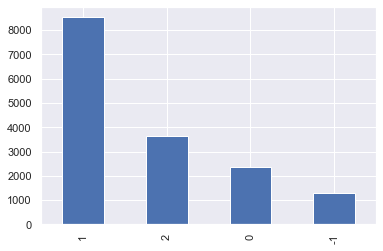

In [36]:
type_labels = list(train_df.sentiment.unique())
print(type_labels)
train_df['sentiment'].value_counts().plot(kind = 'bar')
plt.show()

Clearly the dominant class by a large margin is 1. I will proceed using two techniques to try and combat this. I will use SMOTE to equalize the amount of the different labels and for the other approach I will simply try and train the different models using the class_weight = balanced hyperparamter, where applicable.

## Pre-processing

Cleaning the data in order to eliminate noise.

### Function to clean data

In [50]:
def cleaned_message(tweet):
    # convert to lower case
    tweet = tweet.lower() 
    
    # Remove mentions   
    tweet = re.sub('@[\w]*','',tweet)  
    
    # Remove url's
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)    
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)  
    
    # Remove punctuation
    tweet = re.sub(r"[,.;':@#?!\&/$]+\ *", ' ', tweet)
    
    # Remove diamond
    tweet = re.sub(r"U+FFFD ", ' ', tweet)
    
    # Remove extra whitespace
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
    # Remove space in front of tweet
    tweet = tweet.lstrip(' ')                        
    
    return tweet

In [51]:
train['message'] =train['message'].apply(cleaned_message)

In [52]:
train.head(10)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt researchers say we have three years to act ...,698562
3,1,wired was a pivotal year in the war on climate...,573736
4,1,rt it s and a racist sexist climate change den...,466954
5,1,worth a read whether you do or don t believe i...,425577
6,1,rt mike pence doesn’t believe in global warmin...,294933
7,1,rt six big things we can all do today to fight...,992717
8,1,my yo nephew is inconsolable he wants to die o...,664510
9,1,rt no offense… but like… how do you just not b...,260471


### Tokenization

In [53]:
tokeniser = TreebankWordTokenizer()

In [54]:
train['message'] = train['message'].apply(word_tokenize)

In [55]:
train.head()

,sentiment,message,tweetid
0,1,"[polyscimajor, epa, chief, doesn, t, think, ca...",625221
1,1,"[it, s, not, like, we, lack, evidence, of, ant...",126103
2,2,"[rt, researchers, say, we, have, three, years,...",698562
3,1,"[wired, was, a, pivotal, year, in, the, war, o...",573736
4,1,"[rt, it, s, and, a, racist, sexist, climate, c...",466954


## Lemmatization

In [56]:
nltk.download('wordnet')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Armand\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Armand\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [57]:
def df_lemma(words, lemmatizer):
    return [lemmatizer.lemmatize(word) for word in words]  

In [58]:
train['message'] = train['message'].apply(df_lemma, args=(lemmatizer, ))

In [59]:
train['message'] = [' '.join(map(str, l)) for l in train['message']] 

In [60]:
train.head(10)

,sentiment,message,tweetid
0,1,polyscimajor epa chief doesn t think carbon di...,625221
1,1,it s not like we lack evidence of anthropogeni...,126103
2,2,rt researcher say we have three year to act on...,698562
3,1,wired wa a pivotal year in the war on climate ...,573736
4,1,rt it s and a racist sexist climate change den...,466954
5,1,worth a read whether you do or don t believe i...,425577
6,1,rt mike penny doesn ’ t believe in global warm...,294933
7,1,rt six big thing we can all do today to fight ...,992717
8,1,my yo nephew is inconsolable he want to die of...,664510
9,1,rt no offense… but like… how do you just not b...,260471


## Model building and testing

In [61]:
X = train['message']
y = train['sentiment']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)

In [48]:
TFIDF = TfidfVectorizer(preprocessor = list, tokenizer = list, ngram_range = (1,2), min_df = 2, strip_accents = 'ascii', smooth_idf = False)
vec_train = TFIDF.fit(X_train)
vec_val = TFIDF.fit(X_valid)

TypeError: unhashable type: 'csr_matrix'

In [46]:
X_train = TFIDF.transform(X_train)
X_tr = TFIDF.transform(X_train)

TypeError: unhashable type: 'csr_matrix'

In [69]:
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])

# K-NN Classifier
knn = Pipeline([('tfidf', TfidfVectorizer()),
                ('clf', KNeighborsClassifier(n_neighbors=5, 
                                             metric='minkowski', 
                                             p=2))])

# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1, 
                                         class_weight='balanced', 
                                         max_iter=1000))])
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

# RBF SVC
rbfsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', SVC(class_weight='balanced'))])

In [70]:
# Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# Niave bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

# K - nearest neighbors
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

# Linear regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

# RBF SVC
rbfsvc.fit(X_train, y_train)
y_pred_rbfsvc = rbfsvc.predict(X_valid)

In [23]:
names = ['Random Forest', 'Naïve Bayes',
         'K-NN', 'Logistic Regression', 'Linear SVC',
         'RBF SVC']

In [71]:
print(metrics.classification_report(y_valid, y_pred_rf))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       0.00      0.00      0.00       547
           1       0.55      1.00      0.71      2178
           2       0.00      0.00      0.00       894

    accuracy                           0.55      3955
   macro avg       0.14      0.25      0.18      3955
weighted avg       0.30      0.55      0.39      3955



C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
print(metrics.classification_report(y_valid, y_pred_nb))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       336
           0       0.93      0.05      0.09       547
           1       0.61      0.98      0.76      2178
           2       0.88      0.44      0.58       894

    accuracy                           0.65      3955
   macro avg       0.61      0.37      0.36      3955
weighted avg       0.67      0.65      0.56      3955



C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Armand\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
print(metrics.classification_report(y_valid, y_pred_knn))

              precision    recall  f1-score   support

          -1       0.93      0.11      0.20       336
           0       0.81      0.14      0.24       547
           1       0.92      0.22      0.36      2178
           2       0.26      0.96      0.41       894

    accuracy                           0.37      3955
   macro avg       0.73      0.36      0.30      3955
weighted avg       0.76      0.37      0.34      3955



In [74]:
print(metrics.classification_report(y_valid, y_pred_lr))

              precision    recall  f1-score   support

          -1       0.48      0.65      0.55       336
           0       0.43      0.57      0.49       547
           1       0.86      0.67      0.75      2178
           2       0.68      0.83      0.74       894

    accuracy                           0.69      3955
   macro avg       0.61      0.68      0.63      3955
weighted avg       0.73      0.69      0.70      3955



In [75]:
print(metrics.classification_report(y_valid, y_pred_lsvc))

              precision    recall  f1-score   support

          -1       0.51      0.54      0.53       336
           0       0.50      0.50      0.50       547
           1       0.80      0.77      0.79      2178
           2       0.72      0.77      0.74       894

    accuracy                           0.71      3955
   macro avg       0.63      0.65      0.64      3955
weighted avg       0.72      0.71      0.71      3955



In [76]:
print(metrics.classification_report(y_valid, y_pred_rbfsvc))

              precision    recall  f1-score   support

          -1       0.70      0.49      0.57       336
           0       0.49      0.54      0.51       547
           1       0.83      0.78      0.80      2178
           2       0.70      0.84      0.77       894

    accuracy                           0.73      3955
   macro avg       0.68      0.66      0.66      3955
weighted avg       0.74      0.73      0.73      3955



In [78]:
rbf_op = Pipeline([('tfidf', TfidfVectorizer(max_df=0.8,
                                                    min_df=2,
                                                    ngram_range=(1,2))),
                  ('clf', LinearSVC(C=0.3,
                                    class_weight='balanced',
                                    max_iter=3000))])

rbf_op.fit(X_train, y_train)
y_pred = rbf_op.predict(X_valid)

print(metrics.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

          -1       0.58      0.56      0.57       336
           0       0.53      0.51      0.52       547
           1       0.82      0.80      0.81      2178
           2       0.73      0.80      0.76       894

    accuracy                           0.74      3955
   macro avg       0.66      0.67      0.67      3955
weighted avg       0.74      0.74      0.74      3955



In [24]:
classifiers = [
    RandomForestClassifier(max_depth=5, n_estimators=100),
    MultinomialNB(),
    KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2),
    LogisticRegression(C=1, class_weight='balanced', max_iter=1000),
    SVC(kernel = 'linear', class_weight='balanced'),
    SVC(kernel = 'RBF', class_weight='balanced')
]

In [25]:
results = []

models = {}
confusion = {}
class_report = {}


for name, clf in zip(names, classifiers):
    print ('Fitting {:s} model...'.format(name))
    run_time = %timeit -q -o clf.fit(X_train, y_train)

    print ('... predicting')
    y_pred = clf.predict(X_train)
    y_pred_test = clf.predict(X_valid)

    print ('... scoring')

    f1        = metrics.f1_score(y_train, y_pred, average = 'macro')
    f1_test   = metrics.f1_score(y_valid, y_pred_test, average = 'macro')

    # Save the results to dictionaries
    models[name] = clf
    confusion[name] = metrics.confusion_matrix(y_train, y_pred)
    class_report[name] = metrics.classification_report(y_valid, y_pred)

    results.append([name, f1, f1_test, run_time.best])


results = pd.DataFrame(results, columns=['Classifier', 'F1 Train', 'F1 Test', 'Train Time'])
results.set_index('Classifier', inplace= True)

print ('... All done!')

Fitting Random Forest model...


ValueError: setting an array element with a sequence.

In [86]:
results.sort_values('F1 Test', ascending=False)

,F1 Train,F1 Test,Train Time
Classifier,,,
RBF SVM,0.991781,0.666446,17.327767
Logistic Regression,0.927319,0.635528,0.911477
Linear SVM,0.953561,0.630966,12.478132
Sigmoid SVM,0.884574,0.607672,13.958012
Random Forest,0.999047,0.601588,43.423481
Decision Tree,0.999047,0.516678,3.090721
AdaBoost,0.560130,0.516258,3.349231
Nearest Neighbors,0.801936,0.476397,0.000869


The RBF SVM, Logistics regression and Linear SVM performed the best, I will thus tryand tune their hyper parameters to see if I can improve their performance.

## Hyperparamter tuning

### RBF SVM

In [128]:
RBF_SVM = SVC()
param_grid = {'gamma': [1, 0.1, 0.01, 0.001, 0.0001]} 

In [129]:
grid = GridSearchCV(RBF_SVM, param_grid, scoring = 'f1_macro', refit = True)
grid.fit(X_resampled_train_V, y_resampled_train)

#RBF_SVM.fit(X_resampled_train_V, y_resampled_train)
pred = grid.predict(X_SMOTE_test_V)

In [130]:
print(grid.best_params_)
  
print(grid.best_estimator_)

{'gamma': 1}
SVC(gamma=1)


In [131]:
#grid_pred = grid.predict(X_SMOTE_test_V)
f1_test   = metrics.f1_score(y_SMOTE_test, pred, average = 'macro')
print(f1_test)

0.6664460916701628
